<a href="https://colab.research.google.com/github/kumiori/mec647/blob/andres-conerecipe/playground/nb/discrete_stability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
import json
import pandas as pd
import os

import yaml
import hashlib

def load_data(rootdir):

	# with open(rootdir + '/parameters.pkl', 'r') as f:
	# 	params = json.load(f)

	with open(rootdir + '/parameters.yaml') as f:
		params = yaml.load(f, Loader=yaml.FullLoader)

	with open(rootdir + '/time_data.json', 'r') as f:
		data = json.load(f)
		dataf = pd.DataFrame(data).sort_values('load')

	if os.path.isfile(rootdir + '/signature.md5'):
#         print('sig file found')
		with open(rootdir + '/signature.md5', 'r') as f:
			signature = f.read()
	else:
		print('no sig file found')
		signature = hashlib.md5(str(params).encode('utf-8')).hexdigest()

	return params, dataf, signature 

In [17]:

branch_name = 'main'
branch_name = 'andres-conerecipe'

!rm -rf mec647
try:
  !git clone -b {branch_name} https://github.com/kumiori/mec647.git
#   sys.path.append('mec647/')

except Exception as e:
  print('Something went wrong', e)
  !rm -rf mec647
  !git clone https://github.com/kumiori/mec647.git



Cloning into 'mec647'...
remote: Enumerating objects: 2089, done.
remote: Counting objects: 100% (822/822), done.
remote: Compressing objects: 100% (324/324), done.
remote: Total 2089 (delta 511), reused 759 (delta 464), pack-reused 1267
Receiving objects: 100% (2089/2089), 95.45 MiB | 25.85 MiB/s, done.
Resolving deltas: 100% (1142/1142), done.


In [18]:
## Simple Analytic 
α, α1, α2, e1, e2 = sp.symbols('α α1 α2 e1 e2')
u1, u2 = sp.symbols('u1 u2')
K1, K2 = sp.symbols('K1 K2', positive=True)
s1, s2 = sp.symbols('s1 s2', positive=True)
μ, N = sp.symbols('μ N', positive=True)
w1 = sp.symbols('w1', positive=True)
t = sp.Symbol('t', positive=True)
k = sp.Symbol('k', positive=True)

# _N = 2

K = lambda α: (1-α)/(1+(k-1)*α)
s = lambda α: 1/K(α)

U = 1/2*μ*(K1*u1**2 + K2*(t-u1)**2) * N

S = w1*(α1 + α2) / N

sol_u = sp.solve(U.diff(u1), u1)



In [19]:
!ls mec647/practice/output

discrete-atk-N2


### Example: material parameters

In [27]:
_params = {
    'N': 2,
    'k': 3,
    'k_res': 0.0001,
    'model_dimension': 1,
    'model_type': '1D-discrete',
    'mu': 1,
    'w1': 1}


experiment = 'mec647/practice/output/discrete-atk-N2'
params, data, signature = load_data(experiment)
model_parameters = params.get("model")

_mu, _w1, _k, _N = model_parameters.get("mu"), model_parameters.get("w1"), model_parameters.get("k"), model_parameters["N"]

# _mu, _w1, _k, _N = _params.get("mu"), _params.get("w1"), _params.get("k"), _params["N"]

matpar = {k: _k, w1: _w1, N: _N, μ: _mu}
matpar

{k: 3, w1: 1, N: 2, μ: 1}

In [28]:
E=U.subs(u1, sol_u[0]).simplify()
E

0.5*K1*K2*N*t**2*μ/(K1 + K2)

## Homogeneous response


In [29]:

_E = E.subs({K1: 1/s(α), K2: 1/s(α)})
_E

0.25*N*t**2*μ*(1 - α)/(α*(k - 1) + 1)

In [30]:
F = (E+S)
F = (E+S).subs({K1: 1/s(α), K2: 1/s(α), α1: α, α2: α})

F

0.25*N*t**2*μ*(1 - α)/(α*(k - 1) + 1) + 2*w1*α/N

### Critical damage load

In [31]:
Fa = F.diff(α).simplify()
Fa

-0.25*N*k*t**2*μ/(k*α - α + 1)**2 + 2*w1/N

In [32]:
Fa.subs({α: 0})

-0.25*N*k*t**2*μ + 2*w1/N

In [33]:
sp.solve(Fa, t)[1].subs({α: 0})

2.82842712474619*sqrt(w1)/(N*sqrt(k)*sqrt(μ))

In [34]:
_F = sp.lambdify((α, t), F.subs(matpar), 'numpy')
_F(0, 3)

4.5

In [35]:

tc = sp.solve(Fa, t)[1].subs({α: 0})
tc

2.82842712474619*sqrt(w1)/(N*sqrt(k)*sqrt(μ))

In [36]:
_tc = sp.N(tc.subs(matpar))
_tc

0.816496580927726

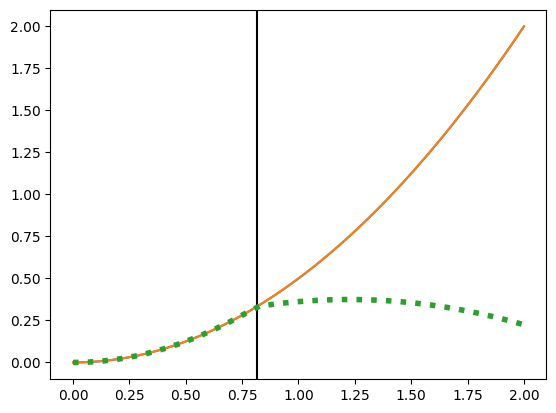

In [38]:
plt.plot(np.linspace(0., 2.), _F(0, np.linspace(0., 2.)))
plt.axvline(_tc, c='k')
plt.plot(data.load, _F(0, data.load.values))
plt.plot(data.load, data.elastic_energy, ls='dotted', lw=4)
